# countland - scanpy

### Samuel H. Church

This vignette shows how `countland` can be used to perform the steps of the standard data processing and clustering workflow from `scanpy`, as listed in [this tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

Load the required packages

Load the required packages and data

In [99]:
import sys

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
plt.style.use('classic')
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import seaborn as sns

import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map="viridis")

np.random.seed(84095) # choose a random seed for reproducibility

scanpy==1.8.2 anndata==0.7.8 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


Here we are using the PBMC3k dataset, here's a look at it before filtering.

In [286]:
adata_raw = sc.read_10x_mtx(
    "../data/Gold_zeros_032922",  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                             # write a cache file for faster subsequent reading

adata_raw.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

... reading from cache file cache/..-data-Gold_zeros_032922-matrix.h5ad


It can be loaded into `countland` from an AnnData object.

In [287]:
import countland as countland
import importlib
importlib.reload(countland)

C = countland.countland(adata_raw,remove_empty=True)
print(C)

initializing countland object...
removing empty cells and genes...

        countland object
        Count matrix has 925 cells (rows) 
         and 15381 genes (columns)
        The fraction of entries that are nonzero is 0.0426
        


## DATA FILTERING 

The `scanpy` tutoral provides instructions on filtering cells, for example cells with more than 200 unique gene observations and genes observed in 3 cells. With `countland` it may not be necessary or helpful to filter the data based on sparsity.

Here, for comparability, we demonstrate how we can filter cells and genes to the same level as `scanpy` using `countland`.

In [288]:
adata = adata_raw.copy()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 17789 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 925 × 11423
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

We can filter the genes to the same level using `countland`

In [289]:
C.SubsetGenes(np.count_nonzero(C.counts,0)>=3,remove_empty=False)

Number of genes: 11423
Number of cells: 925


The next step in a `scanpy` workflow is filtering on the fraction of counts from mitochondrial genes, typically less than 5\%. The same can be accomplished with `countland`. 

However, the Gold dataset does not contain gene names that are annotated as mitochondrial. Here we demonstrate how countland can also be used to score genes based on gene annotations, using regular expression matching.

In [290]:
C.ScoreCells(gene_string="271254$")
C.cell_scores

,names,max_count_value,total_counts,n_features,n_features_above1,n_features_above10,unique_count_values,count_index,feature_match_counts
0,H2228_AAACCTGCAGACACTT-1,24,1008,609,164,6,13,6,0
1,H1975_AAAGATGCACATTTCT-1,16,1002,611,152,3,13,7,0
2,H1975_AAAGATGTCCTTTACA-1,18,1203,696,191,6,14,6,0
3,H2228_AAAGCAACATCAGTAC-1,22,1361,757,197,11,16,7,0
4,H1975_AAATGCCCACTTCGAA-1,11,950,615,141,1,11,6,0
...,...,...,...,...,...,...,...,...,...
920,H1975_TTTGGTTAGATGCCAG-1,13,826,527,117,2,12,6,0
921,HCC827_TTTGGTTCAGTCAGCC-1,37,1636,798,215,16,20,9,0
922,H2228_TTTGGTTTCCATTCTA-1,29,1403,750,204,12,17,7,0
923,H2228_TTTGTCAAGATCCCAT-1,11,742,491,106,3,10,6,0


After quality control and filtering both datasets have 925 cells and 24,224 genes.

## DETECTING HIGHLY EXPRESSED AND HIGHLY VARIABLE FEATURES

`scanpy` detects the genes with highest expression by ranking them according to mean fractional count, and detects highly variable genes by normalizing and logarithmizing the data, and then calculating a form of mean and variance using a dispersion estimate.

normalizing counts per cell
    finished (0:00:00)


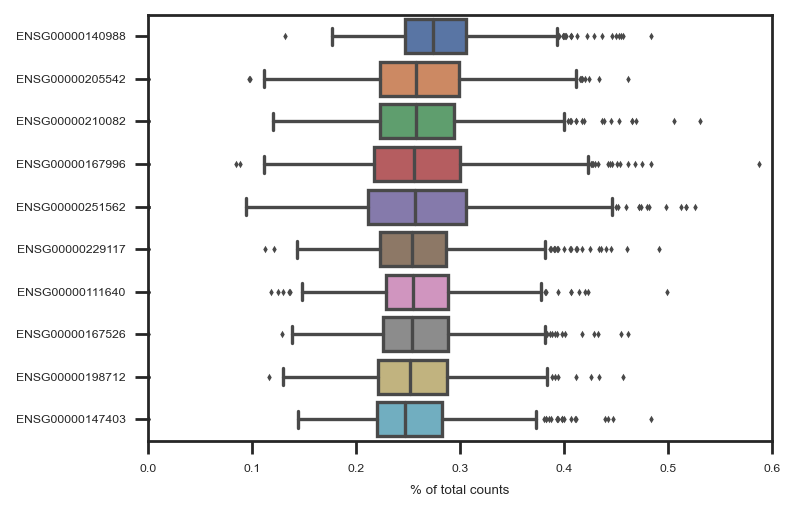

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [319]:
sc.pl.highest_expr_genes(adata, n_top=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

`countland` calculates several count-based measures of gene expression, including the number of unique count observations, and the count-index, which is the largest number of _n_ cells with more than _n_ counts. To standardize sampling depth, we can subsample observations per cell to a fixed number.

In [299]:
C.Subsample(n_counts=350)
C.ScoreGenes(subsample=False)
C.gene_scores

,names,max_count_value,total_counts,n_cells,n_cells_above1,n_cells_above10,unique_count_values,count_index
0,ENSG00000225972,1,7,7,0,0,1,1
1,ENSG00000225630,1,6,6,0,0,1,1
2,ENSG00000237973,2,13,12,1,0,2,1
3,ENSG00000229344,1,4,4,0,0,1,1
4,ENSG00000248527,3,218,195,21,0,3,2
...,...,...,...,...,...,...,...,...
11418,ENSG00000210196,1,12,12,0,0,1,1
11419,ENSG00000276256,1,4,4,0,0,1,1
11420,ENSG00000278817,2,7,6,1,0,2,1
11421,ENSG00000276345,1,19,19,0,0,1,1


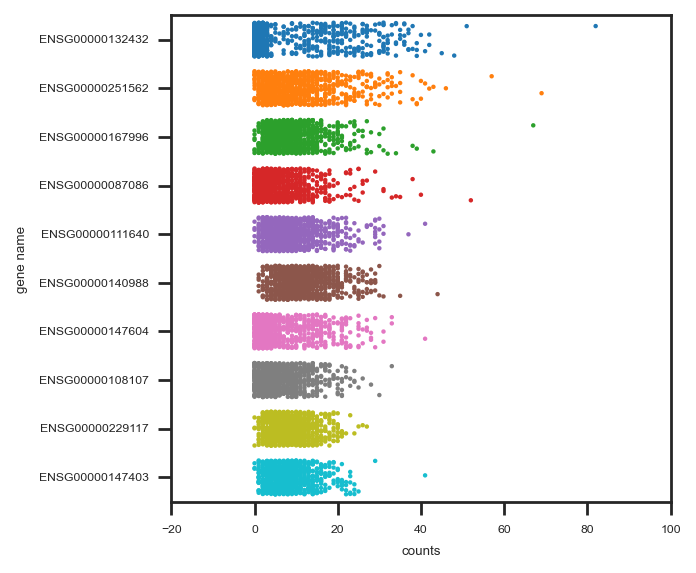

In [300]:
gene_indices = C.gene_scores.sort_values(by="unique_count_values",ascending=False).head(10).index
g = C.PlotGeneCounts(gene_indices)

This visualization compares the genes found to have highest expression using `scanpy` with those identified using several count-based measures in `countland`.

/var/folders/tq/3qjvbb7j0_vg8ksxzrsmwlk80000gn/T/ipykernel_63490/650839051.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scanpy_top = np.nonzero(adata.var.sort_values(by="means",ascending=False).head(10).index[:,None] == C.names_genes)[1]


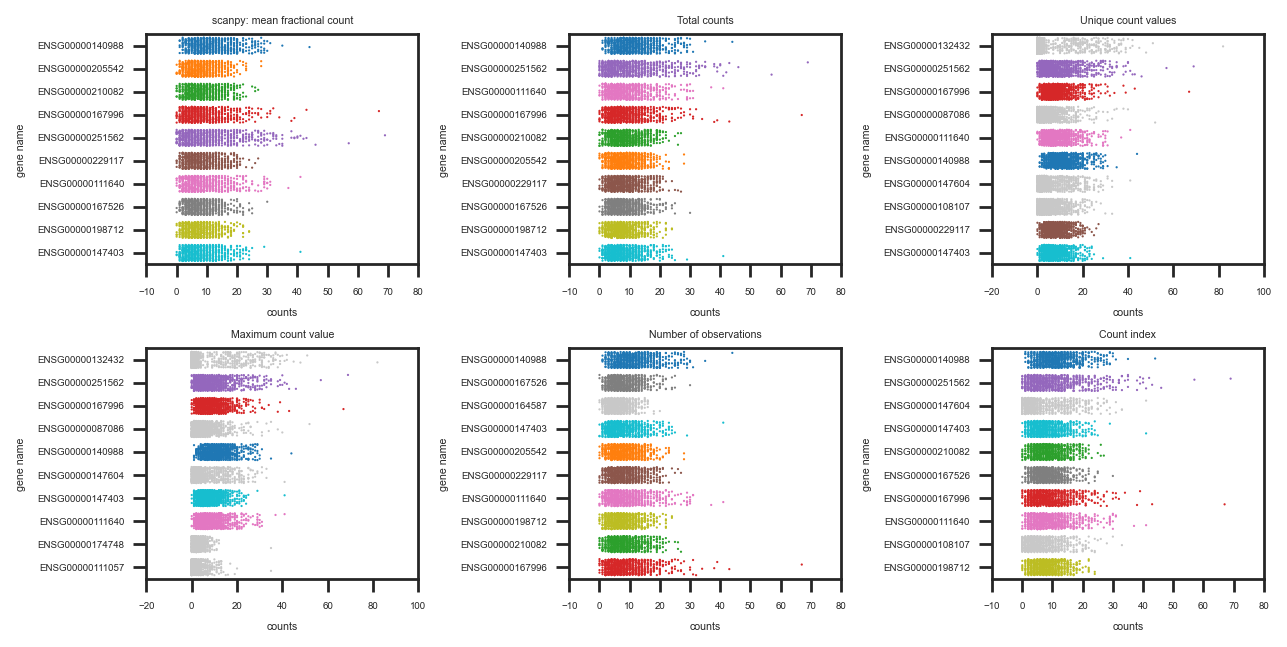

In [326]:
scanpy_top = np.nonzero(adata.var.sort_values(by="means",ascending=False).head(10).index[:,None] == C.names_genes)[1]
max_top = C.gene_scores.sort_values(by="max_count_value",ascending=False).head(10).index
total_top = C.gene_scores.sort_values(by="total_counts",ascending=False).head(10).index
n_top = C.gene_scores.sort_values(by="n_cells",ascending=False).head(10).index
unique_top = C.gene_scores.sort_values(by="unique_count_values",ascending=False).head(10).index
index_top = C.gene_scores.sort_values(by="count_index",ascending=False).head(10).index
all_top = np.unique(np.concatenate([scanpy_top,max_top,total_top,n_top,unique_top,index_top]))

def get_counts(index): 
    appended_data = []
    for g in index:
        name = C.names_genes[g]
        counts = C.counts[:,g].flatten()
        new_df = pd.DataFrame(zip(counts,np.repeat(name,len(counts))),columns=["counts","names"])
        appended_data.append(new_df)
    return(pd.concat(appended_data))

names = C.names_genes[scanpy_top]
other = C.names_genes[all_top[~np.isin(all_top,scanpy_top)]]
unique_names = np.concatenate([names,other])
colors_dict = dict(zip(unique_names,np.append(sns.color_palette("tab10",10).as_hex(),np.repeat("#C8C8C8",len(unique_names)-10)))) # colors to markers

sns.set(font_scale = 0.4);sns.set_style("ticks")

fig, axes = plt.subplots(2,3,figsize=(8,4))

sns.stripplot(ax = axes[0,0],data=get_counts(scanpy_top),x='counts',y='names',size = 1,palette=colors_dict,jitter=0.35)
sns.stripplot(ax = axes[0,1],data=get_counts(total_top),x='counts',y='names',size = 1,palette=colors_dict,jitter=0.35)
sns.stripplot(ax = axes[0,2],data=get_counts(unique_top),x='counts',y='names',size = 1,palette=colors_dict,jitter=0.35)
sns.stripplot(ax = axes[1,0],data=get_counts(max_top),x='counts',y='names',size = 1,palette=colors_dict,jitter=0.35)
sns.stripplot(ax = axes[1,1],data=get_counts(n_top),x='counts',y='names',size = 1,palette=colors_dict,jitter=0.35)
sns.stripplot(ax = axes[1,2],data=get_counts(index_top),x='counts',y='names',size = 1,palette=colors_dict,jitter=0.35)

plt.setp(axes,xlabel="counts",ylabel="gene name")

axes[0,0].title.set_text('scanpy: mean fractional count')
axes[0,1].title.set_text('Total counts')
axes[0,2].title.set_text('Unique count values')
axes[1,0].title.set_text('Maximum count value')
axes[1,1].title.set_text('Number of observations')
axes[1,2].title.set_text('Count index')

fig.tight_layout()
plt.savefig('../figures_and_panels/high_expression_comparison.pdf')


In `countland`, we don't recommend any default filtering scheme based on expression variation. Here, strictly for comparability downstream, we filter the `countland` dataset to the same exact genes as those identified by `scanpy`.


In [107]:
high_var = adata.var.highly_variable

C.SubsetGenes(gene_indices=adata.var.highly_variable.to_numpy())

adata = adata[:, high_var]

removing empty cells and genes...
Number of genes: 3532
Number of cells: 925


## CLUSTER CELLS

The `scanpy` clustering steps are:
- rescale the data
- calculate distances in a principal component space
- calculate the cell-cell neighborhood based on distances
- embed this neighborhood using UMAP to visualize
- identify clusters based on the neighborhood using the leiden algorithm

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


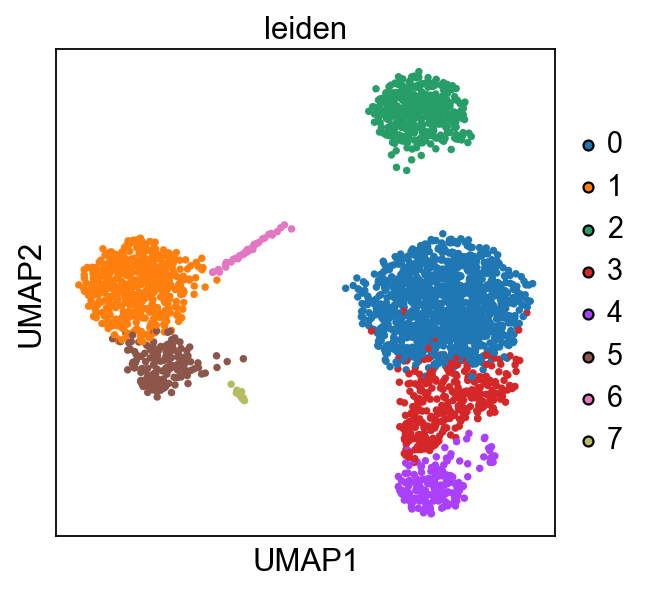

In [15]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

In `countland`, we following these clustering steps:
- calculate an affinity matrix based on pairwise dot products between cells
- use spectral embedding and clustering on this affinity matrix
- visualize with the first two embedding components

Here we have used the same number of clusters as detected with `scanpy`

In [16]:
C.Dot()
C.Embed()

Calculating dot products between rows...
    done.
performing spectral embedding on dot products...
    done.


In [28]:
n_clusters = C.FindEigengap(min_clusters=7)

performing spectral clustering on dot products...
    done.


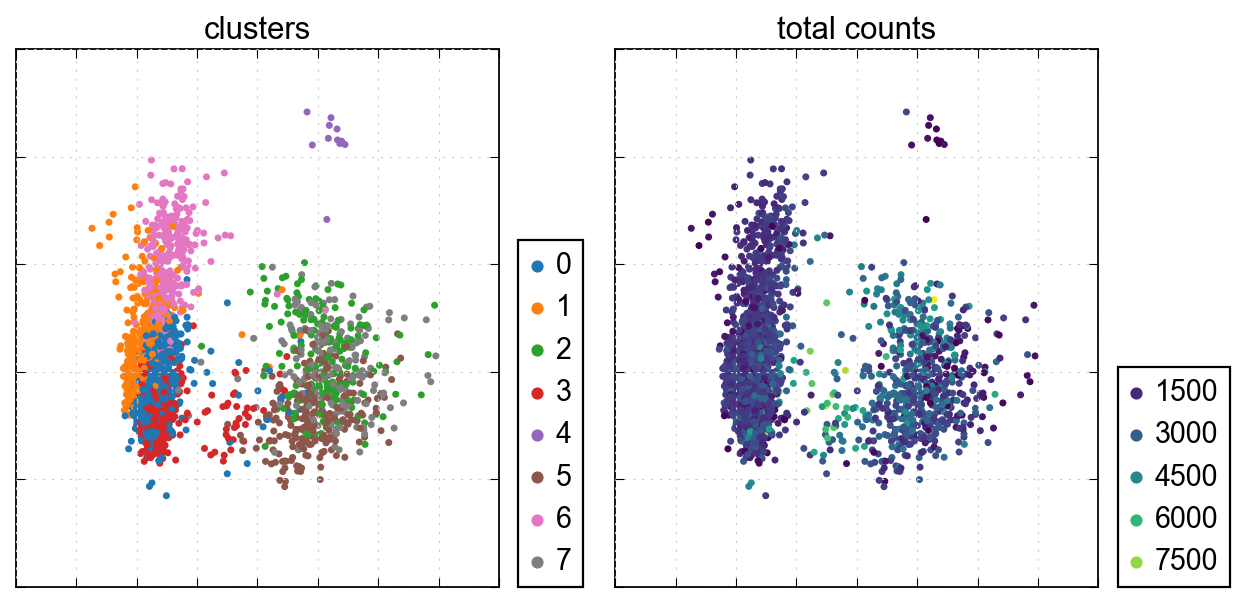

In [29]:
C.Cluster(n_clusters)
C.PlotEmbedding()

## VISUALIZING RESULTS

We can look at the number of cells shared between clusters using a Sankey diagram (note: need to add color here)

In [30]:
cl = C.cluster_labels
sl = adata.obs['leiden'].astype(np.uint) + 8
clusters_df = pd.DataFrame(zip(cl,sl),columns=['countland','scanpy'])
cluster_corr = clusters_df.groupby(['countland', 'scanpy']).size().to_frame(name="size").reset_index()

In [31]:
import plotly.graph_objects as go

In [32]:
a = ["countland cluster: " + str(s) for s in range(8)]
b = ["scanpy cluster: " + str(s) for s in range(8)]
a += b

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 30,
      line = dict(color = "black", width = 0.5),
      label = a,
      color = "black"
    ),
    link = dict(source = cluster_corr['countland'],
                target = cluster_corr['scanpy'],
                value = cluster_corr['size'])
  )])

fig.show()

### SPECTRAL EMBEDDING (countland method)

In [33]:
col_dict = dict(zip(range(10),sns.color_palette("tab10",10)))
scanpy_dict = dict(zip(range(8),[0,5,6,3,4,1,8,2]))
new_scanpy_clusters = pd.Series(adata.obs['leiden'].astype(np.uint)).map(scanpy_dict)

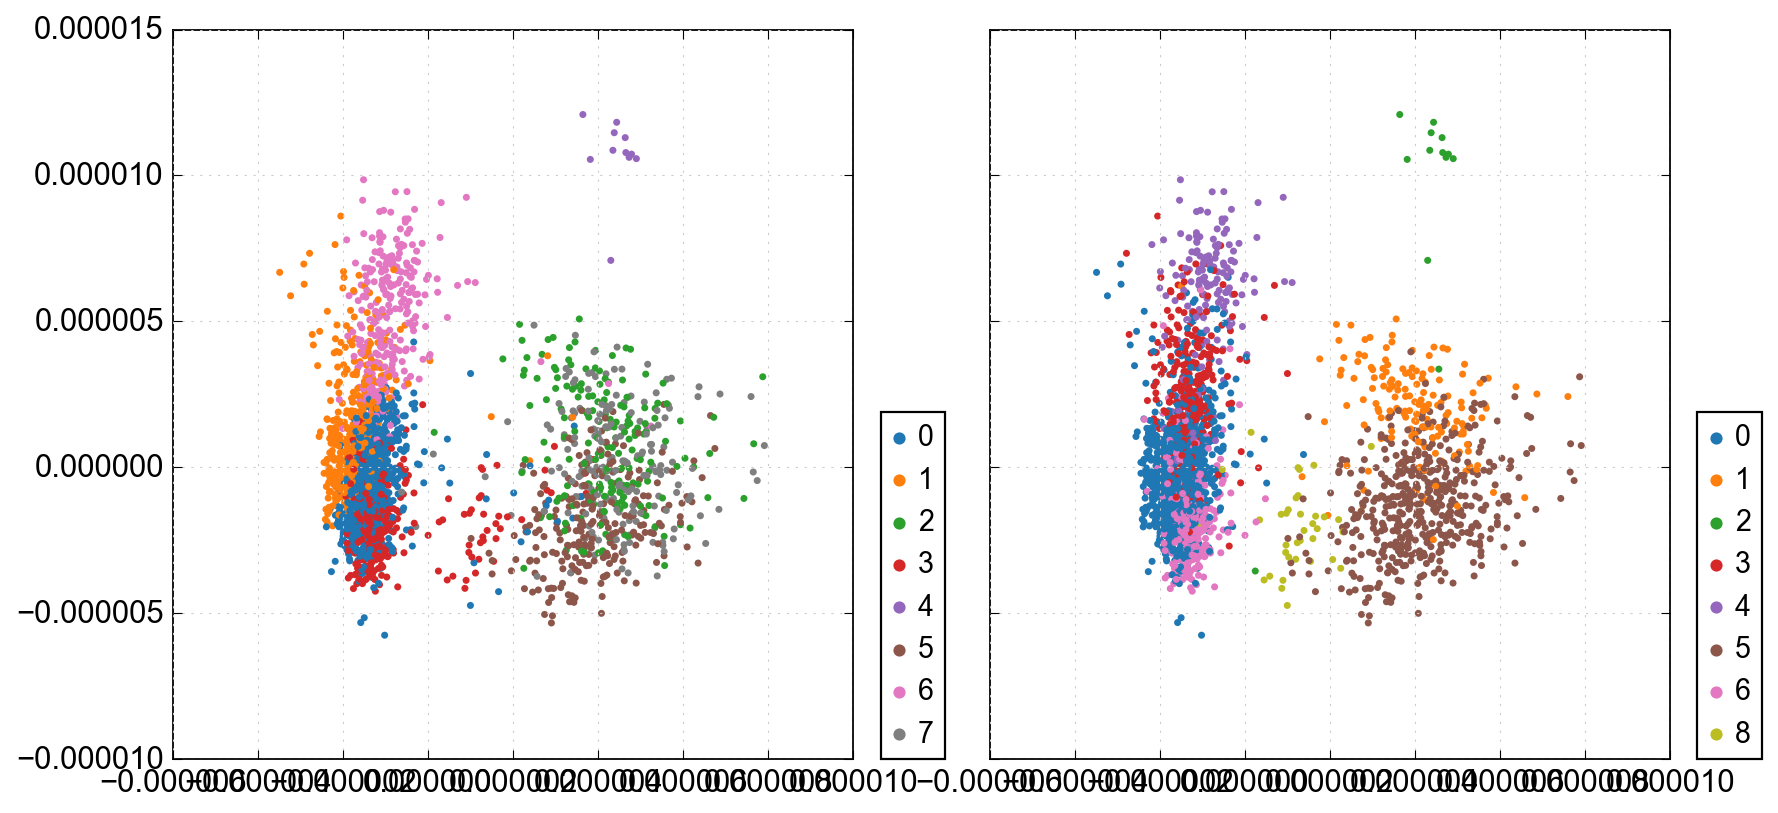

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.scatterplot(ax = ax1,
    x = C.embedding[:, 1],
    y = C.embedding[:, 2],
    hue=C.cluster_labels,
    s = 10,
    linewidth=0,
    palette="tab10")
sns.scatterplot(ax = ax2,
    x = C.embedding[:, 1],
    y = C.embedding[:, 2],
    hue=new_scanpy_clusters,
    s = 10,
    linewidth=0,
    palette=col_dict)
ax1.legend(loc=(1.04,0))
ax2.legend(loc=(1.04,0))

### UMAP EMBEDDING OF TRANSFORMED COUNTS (scanpy method)

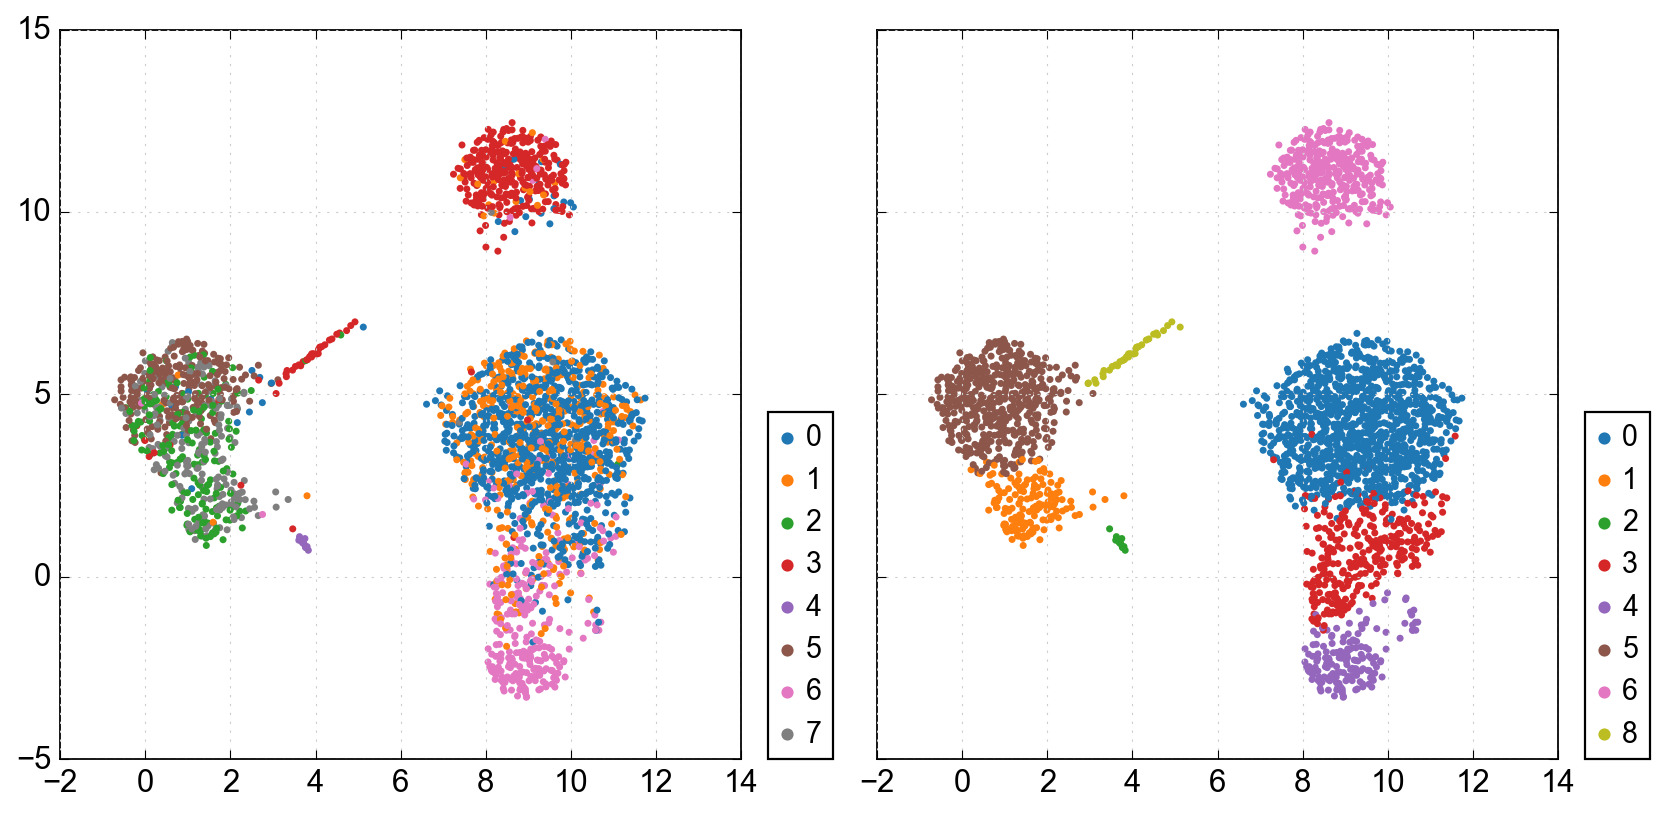

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.scatterplot(ax = ax1,
    x = adata.obsm['X_umap'][:, 0],
    y = adata.obsm['X_umap'][:, 1],
    hue=C.cluster_labels,
    s = 10,
    linewidth=0,
    palette=col_dict)
sns.scatterplot(ax = ax2,
    x = adata.obsm['X_umap'][:, 0],
    y = adata.obsm['X_umap'][:, 1],
    hue=new_scanpy_clusters,
    s = 10,
    linewidth=0,
    palette=col_dict)
ax1.legend(loc=(1.04,0))
ax2.legend(loc=(1.04,0))

### UMAP EMBEDDING OF RAW COUNT VALUES (split the difference)

In [36]:
import umap
u = umap.UMAP(min_dist=0.5)

In [39]:
C.Subsample(n_counts=500)
embed = u.fit_transform(C.subsample)

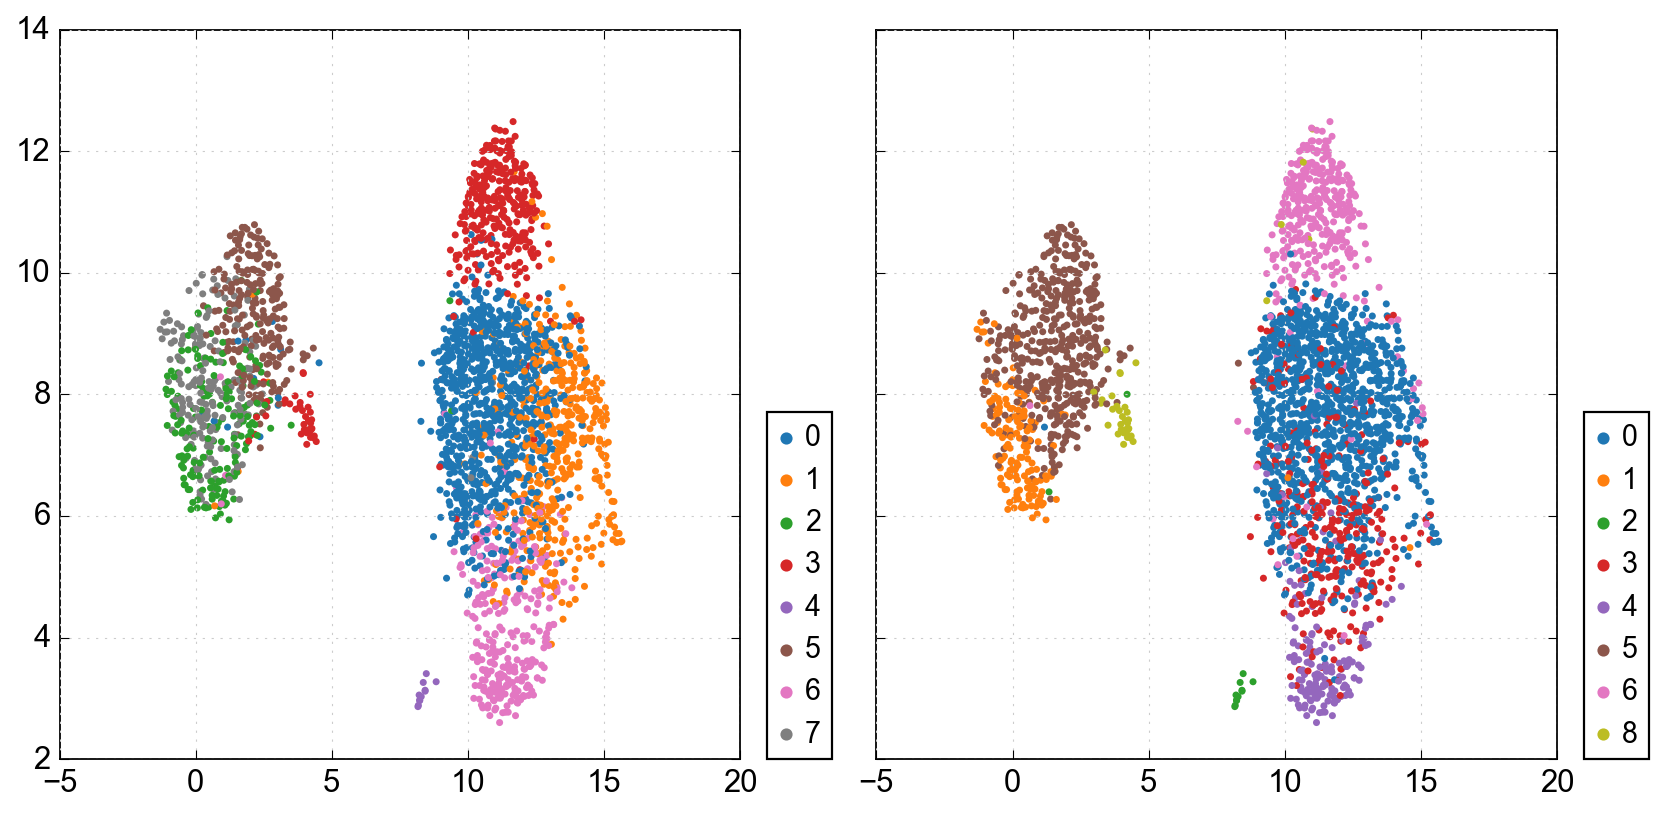

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.scatterplot(ax = ax1,
    x = embed[:, 0],
    y = embed[:, 1],
    hue=C.cluster_labels,
    palette = col_dict,
    s = 10,
    linewidth=0)
sns.scatterplot(ax = ax2,
    x = embed[:, 0],
    y = embed[:, 1],
    hue=new_scanpy_clusters,
    s = 10,
    linewidth=0,
    palette=col_dict)
ax1.legend(loc=(1.04,0))
ax2.legend(loc=(1.04,0))